## _Training: DNN Tracking on STT (Hit Pairs)_

Waleed's TrackML like solution. Its similar to TrackML second solution (difference is in feature columns, prob table, hits in adjacent layers).

- Dense Neural Network (DNN)
- Hit Pair Probability Table
- Cluster Hits into Tracks

Inputs (features) and Targets (Labels) for this method are;

$$X = (h_{i}, h_{j})$$
$$y = 1 / 0$$

Where $h_{i}$ = __*(hit_id, x, y, skewed, layer_id, sector_id, isochrone_radius, particle_id)*__ etc. We can add more information in a hit.

Note
- Train[:,:-1] all columns except last one (-1), Train[:,-1] only last column (-1)

### _For validation accuracy $\ge$ training accuracy_

- [stackoverflow.com](https://stackoverflow.com/questions/43979449/higher-validation-accuracy-than-training-accurracy-using-tensorflow-and-keras)
- [keras.io](https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss)
- [cs231n.github.io](http://cs231n.github.io/neural-networks-3/#sanitycheck)

### _Network Performance_

- We would expect many more epochs needed to minimize the error or we may just have too many hidden nodes.
- If an epoch consists of $11 \times 10^6$ examples, then most of the update work might already be done within the $1^{st}$ epoch. In that case, a **loss graph** over **training example number** rather than over epochs might be more instructive to see initial training behaviour.
- Did you use [early stopping](https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/) to avoid overtraining? **Issue:** it might not use whole data set. **Solution:** use epoch number as hyeprparameter.
- Hyperparameter Tuning (**GridSearchCV**)
- Maybe some data preprocessing might help the network to ease the task of implicit data preprocessing. In other words, you might want to apply a standardizing [(log-)z-score transformation](https://en.wikipedia.org/wiki/Standard_score) before training.

In [1]:
import os, glob

In [2]:
import pickle
import numpy as np
import pandas as pd
import dask.dataframe as dd

from tqdm import tnrange
from tqdm import tqdm_notebook

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [3]:
# TensorFlow (tf.keras)
import tensorflow as tf

In [4]:
# Utility Functions
from prepare import get_event, pandas_events, prepare_train_doublets
from drawing import draw_train_history, draw_pickled_history, draw_single_event, draw_reco_event
from init_models import build_model, init_model

In [5]:
print("tensorflow:", tf.__version__, ", keras:", tf.keras.__version__)

tensorflow: 1.14.0 , keras: 2.2.4-tf


## _Params/Configs_

In [6]:
batch_size=256
epochs=10
val_frac=0.1

In [7]:
# path = os.environ['HOME']+'/current/data_sets/'+'mljuelich/data2/'
path = os.environ['HOME']+'/current/2_deepana/pandaml/data/'

In [8]:
if not os.path.exists('models'):
    os.mkdir('models')

## _Event Vizualization_

In [9]:
# idx = 1
# hits, truth, particles, tubes = get_event(path, event_prefix='event00000000%02d'%idx)
# draw_single_event(event=hits, event_id=idx)

## _Exploratory Data Analysis (EDA)_

In [10]:
# Pull all events using Pandas
hits, truth, particles, tubes = pandas_events(path)

In [11]:
hits.head()

,hit_id,x,y,z,tube_id,skewed,layer_id,sector_id,volume_id,isochrone,depcharge,energyloss,particle_id
0,1,-16.6190,-1.515,35.0,28,0,0,1,9,0.049925,16256100.0,16.25610,10
1,2,-17.4937,-2.020,35.0,134,0,1,1,9,0.281159,9955910.0,9.95591,10
2,3,-18.3684,-1.515,35.0,245,0,2,1,9,0.413188,3994340.0,3.99434,10
3,4,-19.2431,-2.020,35.0,363,0,3,1,9,0.141190,12391400.0,12.39140,10
4,5,-20.1178,-2.525,35.0,487,0,4,1,9,0.159385,6038700.0,6.03870,10


In [12]:
truth.head()

,hit_id,tx,ty,tz,tpx,tpy,tpz,particle_id
0,1,-16.6125,-1.54537,18.0768,-0.237797,-0.051115,0.268606,10
1,2,-17.5543,-1.75329,19.1420,-0.237263,-0.053999,0.268492,10
2,3,-18.2722,-1.91963,19.9554,-0.236697,-0.056308,0.268482,10
3,4,-19.2105,-2.14995,21.0217,-0.235934,-0.059223,0.268491,10
4,5,-20.1527,-2.39287,22.0953,-0.235313,-0.062231,0.268327,10


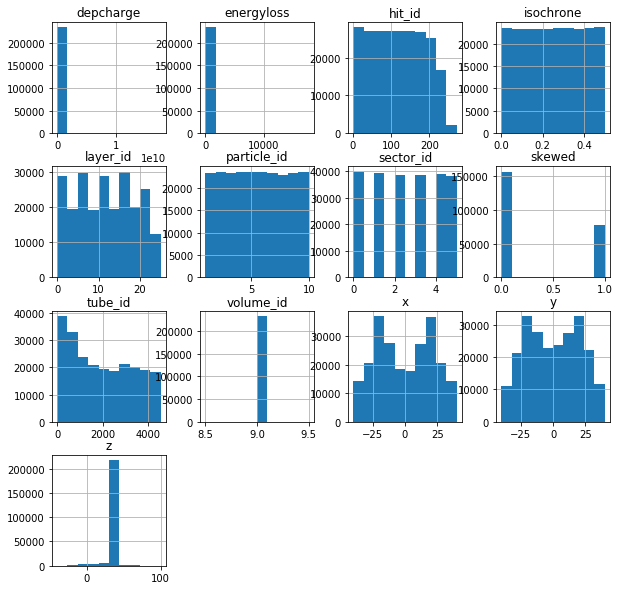

In [13]:
# Pandas: Histogram
_ = hits.hist(figsize = (10,10))

In [ ]:
# Pandas: Scatter Matrix:
#_ = pd.plotting.scatter_matrix(hits, figsize=(12, 12), diagonal='hist')
_ = pd.plotting.scatter_matrix(hits,figsize=(12, 12), diagonal='kde')

/shared/adeel/anaconda/envs/rnn/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left == right == 9.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/shared/adeel/anaconda/envs/rnn/lib/python3.7/site-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom == top == 9.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/shared/adeel/anaconda/envs/rnn/lib/python3.7/site-packages/pandas/plotting/_misc.py:100: UserWarning: Attempting to set identical left == right == 9.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


In [ ]:
# Seaborn: Pair Plot
_ = sns.pairplot(hits)
#_ = sns.pairplot(hits, hue="label", diag_kind="kde", palette="husl")

In [ ]:
# Seaborn: Heatmap
# plt.figure(figsize=(10,10))
_ = sns.heatmap(hits.corr(), annot=True,cmap ='RdYlGn')  # seaborn has very simple solution for heatmap

In [ ]:
sns.jointplot(x = "x", y= "y", data = hits, alpha = 0.05, height = 10);

In [ ]:
hits_per_layer = pd.DataFrame(hits.groupby("layer_id", as_index=False)["hit_id"].count())
hits_per_layer = hits_per_layer.rename(columns = {"hit_id": "num_of_hits"})

sns.barplot(x = hits_per_layer.layer_id, y = hits_per_layer.num_of_hits);

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

#get the unique layer values
layers = hits.layer_id.unique()

#for each layer
for layer in layers:
    #get the data belonging to that layer alone
    lay_hit = hits[hits.layer_id == layer]
    #make a scatterplot of only points of a specific layer
    #and give them colors (using label)
    ax.scatter(lay_hit.x, lay_hit.y, lay_hit.z, s=1, label='layer {}'.format(layer))

#set axes names
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
ax.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(25, 8))
gs = gridspec.GridSpec(nrows=2, ncols=3, left=0.05, right=0.48, wspace=0.5, hspace = 0.3)
ax = fig.add_subplot(gs[0:2,0:2], projection = '3d')
ax2 =fig.add_subplot(gs[0,2])
ax3 =fig.add_subplot(gs[1,2])

#get the unique volume values
volumes = hits.volume_id.unique()

#for each volume
for volume in volumes:
    #get the data belonging to that volume alone
    vol_hit = hits[hits.volume_id == volume]
    #make a scatterplot of only points of a specific volume
    #and give them colors (using label)
    ax.scatter(
        vol_hit.x, 
        vol_hit.y, 
        vol_hit.z, 
        s=0.1, 
        label='volume {}'.format(volume))

    ax2.scatter( 
    x = vol_hit.x,
    y = vol_hit.y,
    s = 0.1,
    label='volume {}'.format(volume))
        
    ax3.scatter(
    x = vol_hit.x,
    y = vol_hit.z,
    s = 0.1,
    label='volume {}'.format(volume))
    
#set axes names
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
ax.set_title('Colored volumes')
ax.legend(loc = "upper left")

ax2.set_xlabel('x (mm)')
ax2.set_ylabel('y (mm)')
ax2.set_title('Colored volumes x-y cross section')

ax3.set_xlabel('x (mm)')
ax3.set_ylabel('z (mm)')
ax3.set_title('Colored volumes x-z cross section')

plt.show()

In [ ]:
sns.jointplot(x = "x", y= "z", data = hits, alpha = 0.05, height = 10);

In [ ]:
sns.jointplot(x = "z", y= "x", data = hits, alpha = 0.05, height = 10);

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=hits.x.values,
    ys=hits.y.values,
    zs=hits.z.values,
    alpha = 0.05
)
ax.set_title('Hit Locations of event 1000')
ax.set_xlabel('X (millimeters)')
ax.set_ylabel('Y (millimeters)')
ax.set_zlabel('Z (millimeters)')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs=truth.tpx.values,
    ys=truth.tpy.values,
    zs=truth.tpz.values,
    alpha = 0.01
)
ax.set_title('Momentum space of event 1000')
ax.set_xlabel('Px (GeV/c)')
ax.set_ylabel('Py (GeV/c)')
ax.set_zlabel('Pz (GeV/c)')
plt.show()

In [ ]:
particles = particles.sample(frac=1)

In [ ]:
particles.iloc[56,0]

In [ ]:
particles.iloc[10,0]

In [ ]:
particles.iloc[5,0]

In [ ]:
### Truth dataset
# For starters, let's see some trajectories from the truth dataset.

#get the information for some particles
truth_0 = truth[truth.particle_id == particles.iloc[56,0]]
truth_1 = truth[truth.particle_id == particles.iloc[10,0]]
truth_2 = truth[truth.particle_id == particles.iloc[5,0]]

#create figure instance
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

#plot each particle's path
ax.plot(
    xs=truth_0.tx,
    ys=truth_0.ty,
    zs=truth_0.tz, marker='o')

ax.plot(
    xs=truth_1.tx,
    ys=truth_1.ty,
    zs=truth_1.tz, marker='o')

ax.plot(
    xs=truth_2.tx,
    ys=truth_2.ty,
    zs=truth_2.tz, marker='o')

ax.set_title('Trajectories of 3 different particle_id')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
plt.show()

In [ ]:
# Now let's automate this a bit and see a larger number of trajectories. Not too 
# large so we can still see some distinct paths.

#get the information of a given particle from the truth dataframe
information = []

#append the information of each desired particle on a list
for i in np.arange(0,100,1):
    #select the true values for a given particle_id
    particle_information = truth[truth.particle_id == particles.iloc[i,0]]
    #append on the list
    information.append(particle_information)

#create figure instance
fig = plt.figure(figsize=(25, 8))
gs = gridspec.GridSpec(nrows=2, ncols=3, left=0.05, right=0.48, wspace=0.5, hspace = 0.3)
ax = fig.add_subplot(gs[0:2,0:2], projection = '3d')
ax2 =fig.add_subplot(gs[0,2])
ax3 =fig.add_subplot(gs[1,2])

#plot the trajectory for each particle on the information list
for trajectory in information:
    
    ax.plot(
    xs=trajectory.tx,
    ys=trajectory.ty,
    zs=trajectory.tz, marker='o')
    
    ax2.scatter( 
    x = trajectory.tx,
    y = trajectory.ty)
    
    
    ax3.scatter(
    x= trajectory.tx,
    y = trajectory.tz)
    
#labels
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
ax.set_title('20 different trajectories')

ax2.set_xlabel('x (mm)')
ax2.set_ylabel('y (mm)')
ax2.set_title('Detector x-y cross section')

ax3.set_xlabel('x (mm)')
ax3.set_ylabel('z (mm)')
ax3.set_title('Detector x-z cross section')
plt.show()

### Vertical Intersection ($x, y$) in Detection Layers
As shown in the figure below, the hits are semi evenly distributed on the detector surface $x, y$.  The white circle in the center of the plot is where the beam pipe lies.  Thanks [agerom] for [the clarification][clar].

The colors represent different detector volumes.  Thanks to [Joshua Bonatt's notebook][josh].

[josh]: https://www.kaggle.com/jbonatt/trackml-eda-etc
[clar]: https://www.kaggle.com/wesamelshamy/trackml-problem-explanation-and-data-exploration/comments#323803
[agerom]: https://www.kaggle.com/artemiosgeromitsos

In [ ]:
# Plotting with Seaborn & Matplotlib:
g = sns.jointplot(hits.x, hits.y, space=1, height=10, color="r")
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.x, v.y, s=3, label='volume {}'.format(volume))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

### Horizonal Intersection ($y, z$) in Detection Layers
You can think of the chart below as a horizontal intersection in the detection surface, where every dot is a hit.  Notice the relationship between the different activity levels in this chart and the one above for $x, y$.

Again, the colors represent different volumes in the detector surface.

In [ ]:
g = sns.jointplot(hits.z, hits.y, space=1, height=10, color="r")
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.z, v.y, s=3, label='volume {}'.format(volume))
    
plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
for volume in volumes:
    v = hits[hits.volume_id == volume]
    ax.scatter(v.z, v.x, v.y, s=1, label='volume {}'.format(volume), alpha=0.5)
ax.set_title('Hit Locations')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
plt.show()

### Initial Position and Momentum
Let's now take a look at the initial position of the particles around the global coordinates' origin $(x, y)=(0,0)$, as shown in the figure below.

The initial position distribution is more concentrated around the origin (less variance) than its hit position (shown above under the Hits Data section).  As the particles hit the detection surface, they tend to scatter as shown in the particle trajectory plot at the end of this notebook.

The colors here show the number of hits for each particle.

g = sns.jointplot(particles.vx, particles.vy,  s=3, height=12)
g.ax_joint.cla()
plt.sca(g.ax_joint)

n_hits = particles.nhits.unique()
for n_hit in n_hits:
    p = particles[particles.nhits == n_hit]
    plt.scatter(p.vx, p.vy, s=3, label='Hits {}'.format(n_hit))

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

## _Preprocessing_

In [ ]:
# hits = hits.drop(['volume_id','depcharge','particle_id'], axis=1)

# df = event[['skewed', 'layer_id']]   # select only 2 columns
# df = df[df['skewed'] == 0]           # all non skewed
# df = df.query('skewed==0')
# df = df[df['skewed'] == 1]           # all skewed, layers = 8,9,2,...15 are skewed
# df = df.query('skewed==1')

# df = df[df['layer_id'] < 8]          # layers = 0,1,2,...7 are before skewed
# df = df[df['layer_id'] > 15]         # layers = 16,17,...24 are after skewed
# df = df[(df['layer_id'] > 7) & 
# (df['layer_id'] < 16)]               # layers = 8,9,2,...15 are skewed

# df.cluster_id.unique()
# df.layer.unique()
# df[df["layer"] < 3].head()
# df[(df["layer"] < 5) & (df["layer"] > 3)].head()
# df.loc[df["layer"].isin([2, 3])].head()
# df.loc[~df["layer"].isin([2, 3])].head()
# df.loc[(df["cluster_id"]==8) & df["layer"].isin([2, 3])].head()

## _Prepare Training Data_

Dataset for training (Hit Doublets)

In [ ]:
%time
X, y = prepare_train_set(path=path, start=0, end=10)

In [ ]:
X.shape

## _Train Model_

In [ ]:
Train=False

In [ ]:
if Train:
    # Keras API
    # model = init_model(fs=10)
    # plot_model(model, to_file='models/model.png', show_shapes=True, show_layer_names=True)
    
    # TF.Keras API
    model = build_model(fs=10)
    tf.keras.utils.plot_model(model, to_file='models/model.png', show_shapes=False, show_layer_names=True)
    
    model.summary()

if Train:
    # Fit the Model
    hist = model.fit_generator(generator=train_batcher, steps_per_epoch=epoch_size, epochs=num_epochs,
                               verbose=1, validation_data=valid_batcher, validation_steps=val_step, 
                               use_multiprocessing=False)

In [ ]:
if Train:
    # Fit the Model
    hist = model.fit(X, y, epochs=20, batch_size=batch_size, validation_split=val_frac, verbose=1)

In [ ]:
if Train:
    # Plot Train History
    draw_train_history(hist);

In [ ]:
if Train:
    # Save the Model
    model.save('models/model.h5')
    
    # Save History (Using Pickle)
    with open('models/model.pickle', 'wb') as hist_file:
        pickle.dump(hist.history, hist_file)

In [ ]:
# ANNVisualizer
# from ann_visualizer.visualize import ann_viz
# ann_viz(model, view=True,  filename="dnn", title="Deep Neural Network")

## _Load Model_

In [ ]:
Load=False

In [ ]:
if Load:
    history = None
    with open('models/model.pickle', 'rb') as pickle_in:
        history = pickle.load(pickle_in)
    draw_pickled_history(history, draw_val=True);

In [ ]:
if Load:
    model = load_model('models/model.h5')

## _Test Model_

*Accuracy/Classification:* `np.mean(y_pred == y_test)`
*Missclassification:* `np.mean(y_pred != y_test`

In [ ]:
# See Model Metrics
# model.metrics_names

In [ ]:
# test_set loss and accuracy
# test_loss, test_acc = model.evaluate(X_test, y_test)

In [ ]:
# Print test_set loss and accuracy
# print("test_loss:", test_loss, ", test_acc:", test_acc)

## _Model Predictions_

*Prediction:* `y_pred = model.predict(X_test)`

In [ ]:
# Get test set predictions
# y_pred = model.predict(X_test)
# y_pred.shape

## _SttHitClusterer_

In [ ]:
class SttHitClusterer:
    def __init__(self, path, model=None, batch_size=128, num_epochs=10):
        
        # Build Model:
        self.model = model
        # self.model = build_model(self.hidden_dim, DetectorGeometry.layer_r.shape[0], self.num_phi_bin)
        # self.model = init_model_dnn(shape=10)
        
        # Params:
        self.path = path
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.val_frac = 0.2

        # Params:
        self.train_input = None
        self.train_target = None
        self.test_input = None
        self.test_pred = None
        
        # Params:
        self.history = None
        self.prepared = False
    
    def prepare_data(self, events, n_events):
        if self.prepared:
            return
        self.prepared = True
        self.train_input, train_target = prepare_pairs(events=events, n_events=n_events)
        
    def fit(self, events, n_events):
        
        # Prepare Data
        prepare_data(self, events, n_events)
        
        # Fit DNN Model
        self.history = self.model.fit(x=self.train_input,
                                      y=self.train_target,
                                      batch_size=self.batch_size,
                                      epochs=self.num_epochs,
                                      validation_split=self.val_frac)
        # Save the Model
        self.model.save("model.h5")
        
    def predict_single_event(self, x_event):
        print("TODO: predict single event")
        
    def param_summary(self):
        print("batch_size:", self.batch_size)
        print("num_epochs:", self.num_epochs)
        print("val. fraction:", self.val_frac)

In [ ]:
clust = SttHitClusterer(path, model)

In [ ]:
clust.param_summary()